In [1]:
import os
import sys
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch
import json
from torch.utils.data import DataLoader
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from mi_toolbox.utils.collate import TokenizeCollator

module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)

model_id = "meta-llama/Llama-3.1-8B-Instruct" #"meta-llama/Llama-3.1-8B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token_id = tokenizer.eos_token_id  
tokenizer.padding_side = 'left'

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",    
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,   
)

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config= bnb_config,
    # dtype=torch.bfloat16,
    device_map="auto",
    trust_remote_code=True,
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

## Get Concept Vectors

In [2]:
with open("./data/word_concept_extraction.json", 'r') as f:
    word_concept_data = json.load(f)

baseline_chats = [
    [{"role": "user", "content": word_concept_data['prompt'].format(word=word)}]
    for word in word_concept_data['baseline_words']
]
target_chats = [
    [{"role": "user", "content": word_concept_data['prompt'].format(word=word)}]
    for word in word_concept_data['target_words']
]

num_baseline_samples = len(baseline_chats)
num_target_samples = len(target_chats)
prompts = tokenizer.apply_chat_template(baseline_chats + target_chats, tokenize=False, add_generation_prompt=True)

concept_cachin_bs = 16
collate_fn = TokenizeCollator(tokenizer=tokenizer)
dl = DataLoader([{'prompts': prompt} for prompt in prompts], batch_size=concept_cachin_bs, collate_fn=collate_fn, shuffle=False)

num_layers = model.config.num_hidden_layers
concept_vector_cache = []
for batch in tqdm(dl):
    with torch.no_grad():
        out = model(
            input_ids = batch['input_ids'].to(model.device),
            attention_mask = batch['attention_mask'].to(model.device),
            output_hidden_states=True
        )
    hidden_states = torch.stack(out['hidden_states']).permute(1, 2, 0, 3) # (bs, tok_pos, layers, hddn_dim)
    concept_vector_cache.extend(hidden_states[:, -1])

concept_vector_cache = torch.stack(concept_vector_cache)
baseline_activation = concept_vector_cache[:num_baseline_samples].mean(dim=0)
target_activations = concept_vector_cache[num_baseline_samples:]
concept_vectors = target_activations - baseline_activation

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:01<00:00,  5.59it/s]


## Intentional Control Thoughts: Two Words

In [44]:
with open("./data/sample_sentences.json", 'r') as f:
    sentence_data = json.load(f)

prompt = "Write '{sentence}'. While writing the sentence, think about {word1} or {word2}. If you think of {word1} don't think about {word2}. If you think about {word2} don't think about {word1}. Don't write anything else than the sentence."

chats = []
word_list = word_concept_data['target_words']
word_pairs = [(word_list[i], word_list[i + 1]) for i in range(0, len(word_list), 2)]
for words, sentence in zip(word_pairs, sentence_data):
    chats.append([
        {"role": "user", "content": prompt.format(word1=words[0], word2=words[1], sentence=sentence)},
        {"role": "assistant", "content": sentence},
    ])
for words, sentence in zip(word_pairs, sentence_data):
    chats.append([
        {"role": "user", "content": prompt.format(word1=words[1], word2=words[0], sentence=sentence)},
        {"role": "assistant", "content": sentence},
    ])
prompts = tokenizer.apply_chat_template(chats, tokenize=False)

concept_cachin_bs = 16
collate_fn = TokenizeCollator(tokenizer=tokenizer)
dl = DataLoader([{'prompts': prompt} for prompt in prompts], batch_size=concept_cachin_bs, collate_fn=collate_fn, shuffle=False)

num_layers = model.config.num_hidden_layers
sentence_hddn_cache = []
for batch in tqdm(dl):
    with torch.no_grad():
        out = model(
            input_ids = batch['input_ids'].to(model.device),
            attention_mask = batch['attention_mask'].to(model.device),
            output_hidden_states=True
        )
    hidden_states = torch.stack(out['hidden_states']).permute(1, 2, 0, 3) # (bs, tok_pos, layers, hddn_dim)
    for sample_hidden_state, sample_input_ids in zip(hidden_states, batch['input_ids']):
        start_of_response = (sample_input_ids == 271).nonzero()[-1] + 1 # 271 = '\n\n' token which occures just before response in llama3.1
        target_states = sample_hidden_state[start_of_response: -1] # last token is eos so we exclude it
        sentence_hddn_cache.append(target_states)


100%|██████████| 4/4 [00:00<00:00,  4.39it/s]


### Plot best Layer

/tmp/ipykernel_4138768/438383372.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, sample_df])


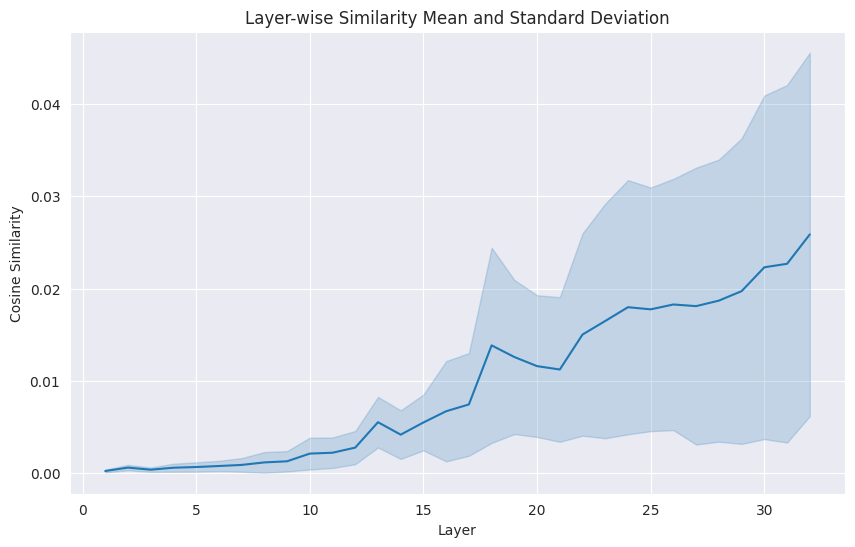

In [45]:
df = pd.DataFrame(columns=['sample', 'layer', 'sim', 'is_non_last_sub_token'])
concept_vector_pairs = [(concept_vectors[i], concept_vectors[i + 1]) for i in range(0, len(concept_vectors), 2)]
hddn_pair_cache = [(sentence_hddn_cache[i], sentence_hddn_cache[i + 25]) for i in range(25)]

for i, ((vec1, vec2), (hddn_1, hddn_2)) in enumerate(zip(concept_vector_pairs, hddn_pair_cache)):
    sim_matrix11 = torch.cosine_similarity(hddn_1, vec1, dim=-1).float().cpu().mean(0)
    sim_matrix12 = torch.cosine_similarity(hddn_1, vec2, dim=-1).float().cpu().mean(0)
    sim_matrix21 = torch.cosine_similarity(hddn_2, vec1, dim=-1).float().cpu().mean(0)
    sim_matrix22 = torch.cosine_similarity(hddn_2, vec2, dim=-1).float().cpu().mean(0)

    div1 = sim_matrix11 - sim_matrix12
    div2 = sim_matrix21 - sim_matrix22

    sample_df = pd.DataFrame(data={
        'sample': [i] * sim_matrix11.size(0),
        'layer': list(range(sim_matrix11.size(0))),
        'sim': torch.abs(div1 - div2) # CAREFUL: ABS torch.abs(
    })
    df = pd.concat([df, sample_df])
df.reset_index(drop=True, inplace=True)

sns.set_style("darkgrid")

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='layer', y='sim', errorbar='sd')

# Add labels and title
plt.title('Layer-wise Similarity Mean and Standard Deviation')
plt.xlabel('Layer')
plt.ylabel('Cosine Similarity')

# Save or show the plot
plt.show()

### Plot token position similarity

* It seems like there is no active control over which word to emphezise

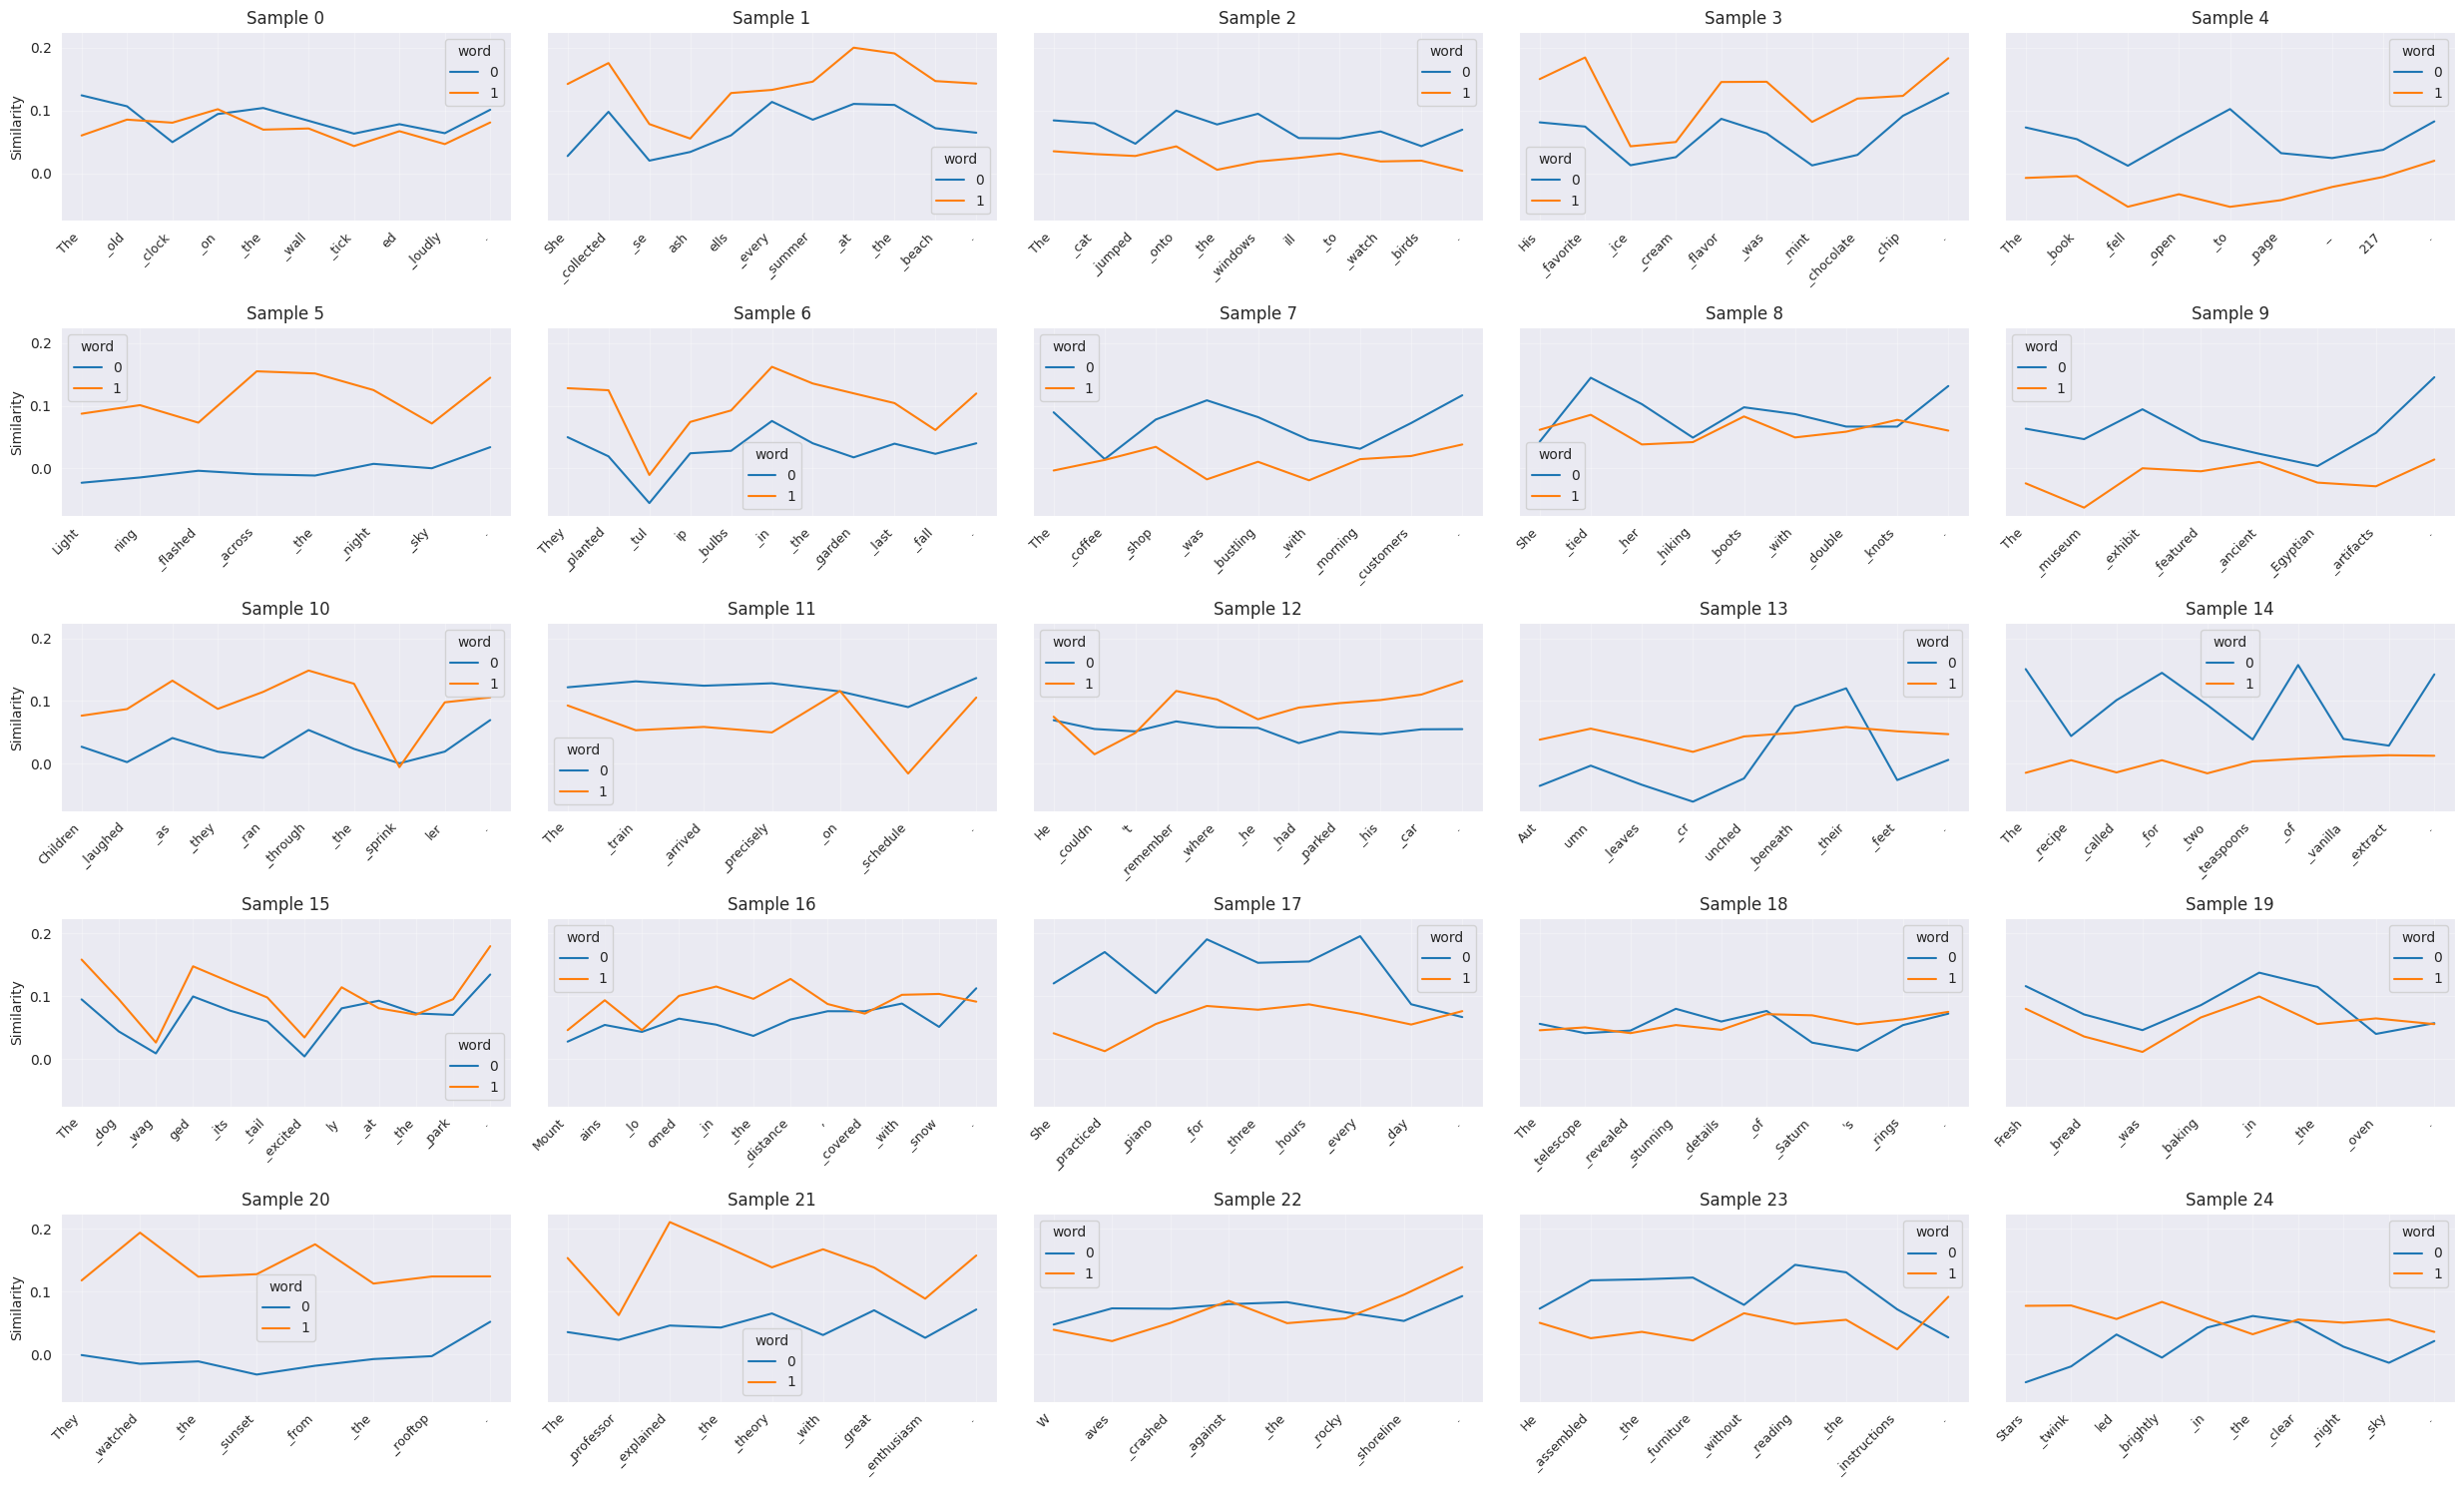

In [46]:
data_list = []
target_layer = 32

# Iterate through your samples
concept_vector_pairs = [(concept_vectors[i], concept_vectors[i + 1]) for i in range(0, len(concept_vectors), 2)]
for i, ((vec1, vec2), sample_hddn_states) in enumerate(zip(concept_vector_pairs, sentence_hddn_cache)):
    # Calculate similarity: Shape (Tokens, Layers)
    # Assuming sample_hddn_states is (Tokens, Layers, Hidden) based on your .mean(0) usage
    sim_matrix1 = torch.cosine_similarity(sample_hddn_states, vec1, dim=-1)
    sim_matrix2 = torch.cosine_similarity(sample_hddn_states, vec2, dim=-1)
    
    # Extract specific layer data: Shape (Tokens,)
    layer_sims1 = sim_matrix1[:, target_layer].float().cpu().numpy()
    layer_sims2 = sim_matrix2[:, target_layer].float().cpu().numpy()
    
    # Store each token's data
    for token_pos, sim in enumerate(layer_sims1):
        data_list.append({
            'sample': i,
            'token_pos': token_pos,
            'sim': sim,
            'word': 0
        })
    
    for token_pos, sim in enumerate(layer_sims2):
        data_list.append({
            'sample': i,
            'token_pos': token_pos,
            'sim': sim,
            'word': 1
        })

df_layer_29 = pd.DataFrame(data_list)

# Setup the grid
fig, axes = plt.subplots(5, 5, figsize=(25, 15), sharey=True)
axes = axes.flatten()

for i in range(25):
    ax = axes[i]
    
    # 1. Plot the data for this sample
    sample_data = df_layer_29[df_layer_29['sample'] == i]
    sns.lineplot(data=sample_data, x='token_pos', y='sim', hue='word', ax=ax)
    
    # 2. Get the specific tokens for this sentence
    # We convert IDs to tokens to ensure we catch special tokens (CLS, SEP, etc.)
    # that match the model's internal states.
    sentence = sentence_data[i]
    tokens = tokenizer.tokenize(sentence)
    tokens = [token.replace('Ġ', '_') for token in tokens]
    
    # 3. specific formatting for the x-axis
    # Set the ticks to match the number of tokens
    ax.set_xticks(range(len(tokens)))
    
    # Set the labels to the actual tokens, rotated 45 degrees
    ax.set_xticklabels(tokens, rotation=45, ha='right', fontsize=9)
    
    # Standard formatting
    ax.set_title(f'Sample {i}')
    ax.grid(True, alpha=0.3)
    
    # Only label Y-axis on the left-most plots to reduce clutter
    if i % 5 == 0:
        ax.set_ylabel('Similarity')
    else:
        ax.set_ylabel('')
        
    ax.set_xlabel('') # often redundant if tokens are visible

plt.tight_layout()
plt.show()